# Temporal response function (TRF) analysis with mTRFpy
In this notebook, we will demonstrate how to use the `mTRFpy` toolbox to perform temporal response function (TRF) analysis
on EEG data and continuous speech stimuli.  

This tutorial is based on the [mTRFpy toolbox documentation](https://mtrfpy.readthedocs.io/en/latest/index.html). 

## 1. Background
The TRF is a multivariate regression between a continuous stimulus and its neural response. The TRF can be applied as a forward model, using stimulus features to predict neural responses or as a backward model, using neural responses to reconstruct the stimulus. Because neural responses are delayed with respect to the stimulus, the regression must be computed across multiple time lags. The TRF predicts the estimand (i.e. neural response in a forward or stimulus in a backward model) as a weighted combination of predictor features. The model weights are chosen to minimize the mean squared error (MSE) between estimand and it’s prediction. This is implemented in the following matrix multiplication: $$w = (X^\intercal X+\lambda I)^{-1}X^\intercal y$$
Where $X$ is a matrix of time-lagged input features and $y$ is a vector of output features. $(X^\intercal X)^{-1}$ is the inverse autocovariance matrix of the predictor which accounts for the fact that both natural speech and brain signals are correlated with themselves over time. $\lambda$ is the regularization parameter that can be optimized to improve stability and avoid overfitting. $I$ is the identity matrix,  $X^\intercal y$ is the covariance matrix of predictor and estimand (Crosse et al. 2016). 

In [1]:
# Import all required libraries
from mtrf.model import load_sample_data, TRF
from mtrf.stats import crossval, nested_crossval, pearsonr, permutation_distribution
from mne.channels import make_standard_montage
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

## 2. Loading sample data

We are using the sample data provided with the `mTRFpy` toolbox. The dataset consists of continuous EEG roughly 2 minutes long, recorded with a 128 channel EEG system (Biosemi) in response to a continuous speech stimulus (audiobook) from a single participant. The EEG data have already been pre-processed and referenced to the mastoid channels. The 16-band spectrogram of the speech stimulus is also provided with the EEG data. The dataset can be found in the current directory under the name `speech_data.npy`. We'll use the `load_sample_data` function to load the data which provides convenient features such as normalization and segmenting the data into smaller chunks.

In [2]:
# Load sample data
stimulus_spectrogram, response, fs = load_sample_data(n_segments=10, normalize=True)

Above, `stimulus_spectrogram` is a list of length 10 containing the 16-band spectrogram of the speech signal for the 10 segments. Similarly, `response` is also a list of length 10 containong the 128-channel EEG recordings for the 10 segmetns. Both are sampled at 128 Hz sampling rate which is stored in `fs`.

Below, we do some further processing to ensure that all stimuli and responses have the same number of samples across the segments to make plotting easier. 

In [3]:
# Ensure all stimuli and responses have the same number of samples
min_length = min(resp.shape[0] for resp in response)
response = [resp[:min_length, :] for resp in response]
stimulus_spectrogram = [stim[:min_length, :] for stim in stimulus_spectrogram]
n_samples = response[0].shape[0]
times = np.linspace(0, n_samples/fs, n_samples)

To demonstrate the TRF analysis, we will use the envelope of the speech signal. The envelope is a single time series that captures the amplitude fluctuations of the speech signal over time. We can compute it from the spectrogram by averaging across the frequency bands. 

In [4]:
# compute speech envelope
stimulus_envelope = [np.mean(stim, axis=1, keepdims=True) for stim in stimulus_spectrogram]

Let's have a look at the data! Below we plot the first segment of the stimulus spectrogram, envelope and a single channel (Cz) of the EEG response. 

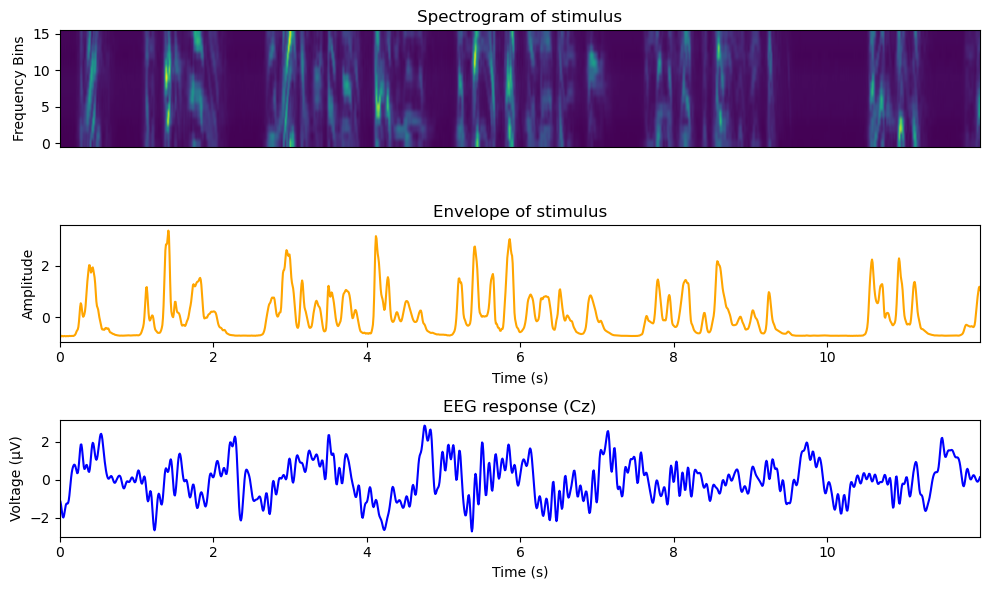

In [5]:
# Plot the spectrogram and the envelope of th first stimulus segment
segment_idx = 0  # We will plot the first segment
# The first channel (A1 in the ABC  system) in the the Biosemi128 montage used here corresponds to Cz in the more common 10-20 system
channel_idx = 0
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
# plot the spectrogram as an image
ax[0].imshow(stimulus_spectrogram[segment_idx].T, aspect='auto', origin='lower', cmap='viridis')
ax[0].set_xticks([])  # Hide x-ticks for spectrogram
ax[0].set_title('Spectrogram of stimulus')
ax[0].set_ylabel('Frequency Bins')
# plot the envelope
ax[1].plot(times, stimulus_envelope[segment_idx], label='Envelope', color='orange')
ax[1].set_xlim(0, times[-1])
ax[1].set_title('Envelope of stimulus')
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Time (s)')
# plot the EEG response for the first channel (Cz)
ax[2].plot(times, response[segment_idx][:, channel_idx], color='blue')
ax[2].set_xlim(0, times[-1])
ax[2].set_title('EEG response (Cz)')
ax[2].set_ylabel('Voltage (µV)')
ax[2].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

You can change the `segment_index` variable to plot different segments of the data for exploration. The `channel_index` variable allows you to select a different EEG channel to plot. 

## 3. Forward model
To fit a forward model, we simply create an instance of the TRF class, and use the `TRF.train()` to fit the model. The `stimulus` argument is the envelope of the speech signal, `response` is the EEG data, `fs` is the sampling rate. The time interval for the time lags is defined using the `tmin` and `tmax` arguments. `TRF.train()` will determine the number of time lags based on the sampling rate and the chosen time interval. For now, we will simply set the `regularization` parameter to 1000, but the next section goes into detail on how to select this parameter. 

In [6]:
fwd_trf = TRF(direction=1)
tmin, tmax = 0, 0.4  # range of time lag
regularization = 1000 # regularization parameter lambda
fwd_trf.train(
    stimulus=stimulus_envelope,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=regularization
)

After the model has been trained, we can use the `TRF.predict()` method to generate a prediction of the neural response based on the stimulus. When provided with both stimulus and response, `TRF.predict()` will also evaluate the prediction’s accuracy. Per default, it computes Pearson’s correlation between the predicted and observed data as a metric for model accuracy. We will use this metric throughout this tutorial but other metrics are also available, see the [mTRFpy documentation](https://mtrfpy.readthedocs.io/en/latest/index.html) for more details. 

In [7]:
prediction, r_fwd = fwd_trf.predict(
    stimulus=stimulus_envelope,
    response=response,
    average=False  # keep channel-level prediction accuracy
)
print(f"correlation between actual and predicted response: {r_fwd.mean().round(3)}")

correlation between actual and predicted response: 0.077


As you can see the prediction accuracy is rather moderat. Keep in mind that we are using a very small amount of data here. That being said, this is a typical result for a forward model using the envelope of the speech signal as stimulus. 

Now we can have a look at the predicted response and how it compares to the observed response. Because we can't look at all 128 channels at once, we will plot the predicted response for the channel which had the highest prediction accuracy. Feel free to change the x-axis limits to zoom in the plot.

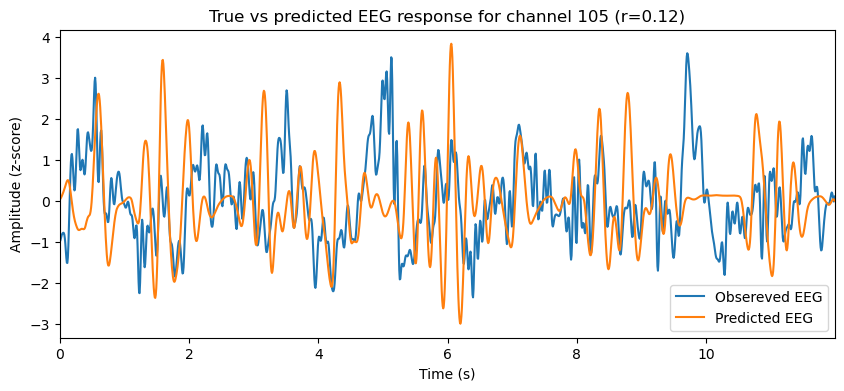

In [8]:
# We can't look at all channels at once, so we pick the channel with the best 
# prediction accuracy
idx = np.argmax(r_fwd)  # pick the channel with the best prediction
# Regularization changes the scale so we stanardize for plotting
pred_z = zscore(prediction[0], axis=0)
resp_z = zscore(response[0], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(times, resp_z[:, idx], label='Obsereved EEG')
plt.plot(times, pred_z[:, idx], label='Predicted EEG')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (z-score)')
plt.xlim(0, times[-1])
plt.legend()
plt.title(f'True vs predicted EEG response for channel {idx} (r={r_fwd[idx]:.2f})')
plt.show()

The `TRF.plot()` method allows a quick visualization of the weights after training the TRF. Because the weight matrix is three-dimensional (inputs-by-lags-by-outputs) visualization requires selecting from or averaging across one of the dimensions. In the below example, we are plotting the TRFs weights over time for the speech envelope for each EEG channel as well as the global field power (i.e. standard deviation across all channels).

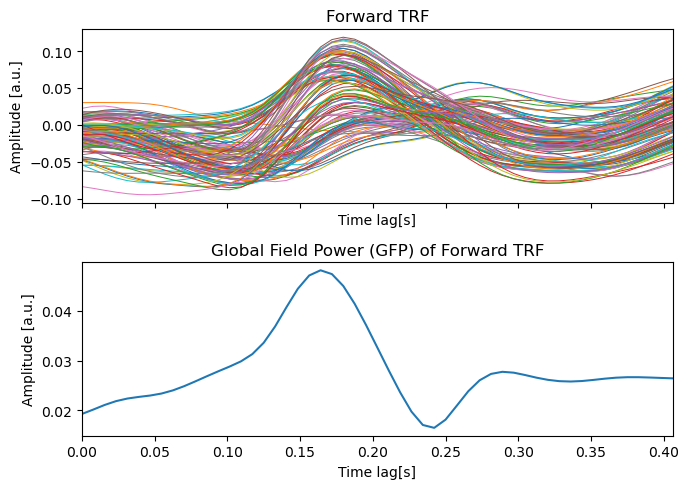

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
fwd_trf.plot(axes=ax[0], show=False)
fwd_trf.plot(channel='gfp', axes=ax[1], show=False)
ax[0].set_title('Forward TRF')
ax[1].set_title('Global Field Power (GFP) of Forward TRF')
plt.tight_layout()
plt.show()

The mTRFpy toolbox provides a handy method (`TRF.to_mne_evoked()`) to convert the estimated TRFs to MNE-Python's `mne.Evoked` objects. This allows us to utilize MNE's powerful visualization tools to plot the TRFs. The method requires information about channel locations (here, we use a standard montage for the biosemi system) and returns a list of `mne.Evoked` instances - one for each feature in the TRF (in this particular case only one as we're only using the envelope as feature). 

No projector specified for this dataset. Please consider the method self.add_proj.


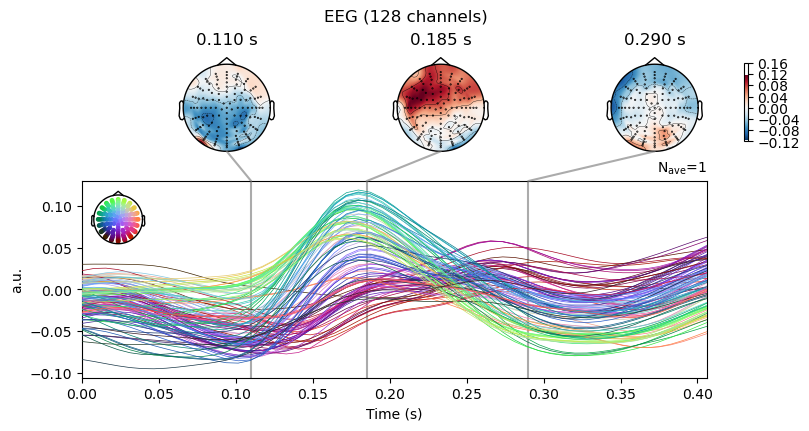

In [10]:
# use standard montage for the EEG system used for recording the response
montage = make_standard_montage('biosemi128')
evokeds = fwd_trf.to_mne_evoked(montage)
_ = evokeds[0].plot_joint(
    times=[0.11, 0.185, 0.29],
    topomap_args={"scalings": 1},
    ts_args={"units": "a.u.", "scalings": dict(eeg=1)}
)

As you can see the TRF weight timecourses and topographies are similar to an auditory evoked response with a negative deflection (N1) around 100 ms after stimulus onset, a positive deflection (P2) around 200 ms. 

### 3.1 Overfitting
Fitting the TRF model to all data segments at once leads to overfitting, which overestimates the model's accuracy and results in poor generalisation to unseen data. To avoid this, we can use a cross-validation approach, where we fit the model to a subset of the data and evaluate its performance on the remaining data. This way, we can estimate the model's generalization performance and avoid overfitting. 

The `mTRFpy` package provides a convenient way to perform cross-validation using the `mtrf.stats.crossval()` function. This function uses a k-fold cross-validation approach, where the data is split into k subsets, and the model is trained on k-1 subsets and tested on the remaining subset. The process is repeated k times, and the average performance across all folds is reported. 

In [11]:
# Use cross-validation to estimate the model's generalization performance
r_fwd = crossval(
    model=TRF(direction=1), 
    stimulus=stimulus_envelope,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=regularization
)
print(f"mean correlation between actual and predicted response: {r_fwd.mean().round(3)}")

Cross-validating[##################################################] 10/10

mean correlation between actual and predicted response: 0.031


### 3.2 Regularization
Remember the $\lambda$ parameter in the TRF equation above? It is the regularization parameter that we fixed at a value of `regularization=1000` above. But what does it actually do? The regularization parameter controls the trade-off between fitting the data well and keeping the model weights small. A small value of $\lambda$ will lead to a model that fits the data very well, but may overfit and not generalize well to new data. A large value of $\lambda$ will lead to a model that is more stable and generalizes better, but may not fit the data as well. 

#### Excercise
Next, explore how the regularization parameter affects the model fitting. Try different values for $\lambda$ and plot the resulting TRF weights. Make sure to try a model with no regularization (i.e., `regularization=0`) as well!

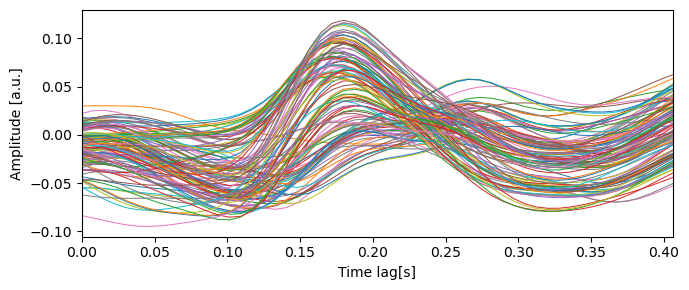

In [12]:
fwd_trf_reg = TRF(direction=1)
fwd_trf_reg.train(
    stimulus=stimulus_envelope, 
    response=response, 
    fs=fs, 
    tmin=tmin, 
    tmax=tmax, 
    regularization=1000 # the original regularization parameter is 1000, feel free try different values and plot the results
) 
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
fwd_trf_reg.plot(axes=ax, show=False)
plt.tight_layout()
plt.show()

You may want to plot the TRFs with and without regularization side by side to compare them. Is there an obvious difference between them? 

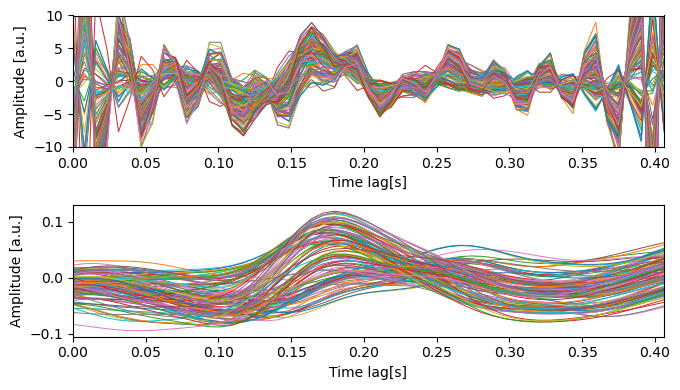

In [13]:
# Compare the TRFs with and without regularization
fwd_trf_noreg = TRF(direction=1)
fwd_trf_noreg.train(
    stimulus=stimulus_envelope, 
    response=response, 
    fs=fs, 
    tmin=tmin, 
    tmax=tmax, 
    regularization=0
)
fig, ax = plt.subplots(2, 1, figsize=(7, 4))
fwd_trf_noreg.plot(feature=0, axes=ax[0], show=False)
fwd_trf_reg.plot(axes=ax[1], show=False)
ax[0].set_ylim(-10, 10)
plt.tight_layout()
plt.show()

We can now use a more systematic approach to find the optimal regularization parameter. 

Cross-validating[##################################################] 10/10....] 0/20

Cross-validating[##################################################] 10/10....] 1/20

Cross-validating[##################################################] 10/10....] 2/20

Cross-validating[##################################################] 10/10....] 3/20

Cross-validating[##################################################] 10/10....] 4/20

Cross-validating[##################################################] 10/10....] 5/20

Cross-validating[##################################################] 10/10....] 6/20

Cross-validating[##################################################] 10/10....] 7/20

Cross-validating[##################################################] 10/10....] 8/20

Cross-validating[##################################################] 10/10....] 9/20

Cross-validating[##################################################] 10/10....] 10/20

Cross-validating[####################################

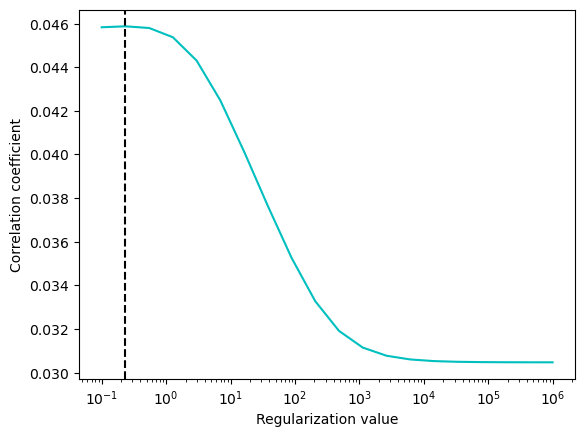

Best regularization value: 0.234, r=0.046


In [14]:
# Use a range of regularization values to find the best value
regularization = np.logspace(-1, 6, 20)

trf = TRF(metric=pearsonr)  # use pearsons correlation
r = trf.train(
    stimulus=stimulus_envelope,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=regularization
)
fig, ax = plt.subplots()
ax.semilogx(regularization, r, color='c')
ax.set(xlabel='Regularization value', ylabel='Correlation coefficient')
ax.axvline(regularization[np.argmax(r)], linestyle='--', color='k')
plt.show()
print(f"Best regularization value: {regularization[np.argmax(r)].round(3)}, r={r.max().round(3)}")

As you can see, the best regularization value is rather small, between 0 and 1. This is most likely because we are only using a single feature (the envelope) to predict the EEG response, which is not very complex. Had we used a more complex feature set, such as the 16-band spectrogram, we would have needed a larger regularization value to avoid overfitting. (You'll have a chance to try this later!) Apart from model complexity, the other main determining factor for the regularization value is the amount of data you have. The more data you have, the less regularization you need. Since in our case we don't have a lot of data either, low model complexity clearly outweighs data quantity in determining the best regularization value. 

### 3.3 Overfitting due to fine-tuning $\lambda$ 
Optimizing the value of $\lambda$ creates another source of overfitting. This is because, we selected the best $\lambda$ on the whole data set. Thus, optimizing on the same data used to validate the model inflates its accuracy estimate. To avoid this, we must incorporate selecting the best $\lambda$ value in the cross-validation loop. The way to achieve this is called **nested cross-validation**. As the name suggest this is basically a cross-validation within a cross-validation loop. The outer loop splits the data into a test and a train/validate set. The inner loop uses the train/validate set and runs a cross-validation to find the best value for $\lambda$. Then this $\lambda$ value is used in the test set to evaluate the final model. This way, the data used to determine the model’s accuracy is never part of the optimization process. The data are rotated in the outer loop, so that each segment is used for testing once and for each iteration of the outer loop, a full cross-validation loop is performed using the remaing k-1 segments to find the best value for $\lambda$. This makes the nested cross-validation time consuming but it will produce an unbiased estimate of the model’s accuracy while optimizing $\lambda$.

This procedure is implemented in the `mtrf.stats.nested_crossval()` function which returns the accuracy metric for each test set as well as the value of selected from each train/validate set. In the examle below, we use it to compute and unbiased estimate of the models accuracy and compare it to the highest accuracy obtained during optimization in the previous section:

In [15]:
r_unbiased, best_regularization = nested_crossval(
    model=trf,
    stimulus=stimulus_envelope,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=regularization
)
print(f'With overfitting, correlation between the actual and predicted response is {r.max().round(4)} \n')

print(f'Unbiased correlation between the actual and predicted response is {r_unbiased.mean().round(4)}')

Cross-validating[##################################################] 9/9......] 0/20

Cross-validating[##################################################] 9/9......] 1/20

Cross-validating[##################################################] 9/9......] 2/20

Cross-validating[##################################################] 9/9......] 3/20

Cross-validating[##################################################] 9/9......] 4/20

Cross-validating[##################################################] 9/9......] 5/20

Cross-validating[##################################################] 9/9......] 6/20

Cross-validating[##################################################] 9/9......] 7/20

Cross-validating[##################################################] 9/9......] 8/20

Cross-validating[##################################################] 9/9......] 9/20

Cross-validating[##################################################] 9/9......] 10/20

Cross-validating[####################################

As expected, fine-tuning the regularization parameter doesn't change model performance much when decoding the envelope (see discussion above). This will have a much larger effect when using a more complex model (like the 16-band spectrogram) as stimulus feature. Indeed most of the time we use more complex models, so fine-tuning the regularization parameter is a crucial step in TRF analysis.

### 3.4 Statistical inference
We use permutation testing to determine the significance of an estimate. For each permutation, stimuli and responses are randomly shuffled so that the association between them is broken. The TRF model is then evaluated as normal using cross-validation. This whole procedure is repeated a number of times, resulting a permutation distribution that reflects the expected correlation and error if there is no causal relationship between stimulus and response. 

This is implemented in the function `mtrf.stats.permutation_distribution()`. The number of permutations is set by the `n_permute` parameter (in this demo we use 100 but usually you would use more in an actual analysis) and the number of cross-validation folds `k` should be the same that was used to estimate model accuracy for the actual data. Finally, we then compute the p-value of the observed correlation as the number of elements in the permuted distribution that are equal or higher divided by the number of permutations.

Preparing models[##################################################] 100/100

Permuting[##################################################] 100/100



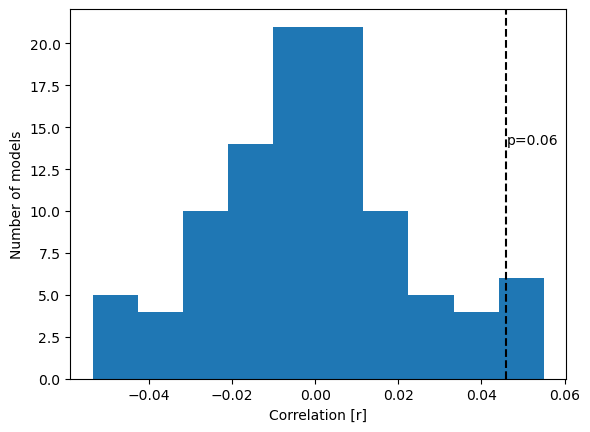

In [16]:
r_obs = 0.046 # the previously observed correlation
regularization = 0.234 # the lambda value that worked best
n_permute = 100
 # number of permutations
trf = TRF()  # use forward model
tmin, tmax = 0, 0.4  # range of time lags
r_perm = permutation_distribution(
    model=trf,
    stimulus=stimulus_envelope,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=regularization,
    n_permute=n_permute
)
p = sum(r_perm>=r_obs)/len(r_perm)
plt.hist(r_perm, bins=10)
plt.axvline(x=r_obs, ymin=0, ymax=1, color='black', linestyle='--')
plt.xlabel('Correlation [r]')
plt.ylabel('Number of models')
plt.annotate(f'p={p.round(3)}', (r_obs, 14))
plt.show()

As you can see, the observed correlation falls just around the 95% confidence interval of the permutation distribution, and may or may not come out significant at level of $\alpha = 0.05$ in the particular execution of the code. You may want to try running the code multiple times to see how the p-value changes. Increasing the number of permutations (e.g. 1000) will also increase the stability of the p-value, but will take longer to compute. Overall, given that this is a single subject analysis, whith limited data (2 minutes of EEG recording), this is an encouraging result! 

### 3.5 Multivariate models 
You may ask yourself, is there a way to predict the EEG response using more than one feature? The answer is yes! Indeed the 'm' in the 'mTRF' stands for 'multivariate'. The TRF model can naturally extend to use multiple features. One such feature set could be the 16-band spectrogram of the speech stimulus (each band representing a feature). This is done by simply stacking the additional features in the feature array, so it becomes a 2D array of size n_samples x n_features. The list of these arrays for each stimulus segment are then passed as the `stimulus` argument to the `TRF.train()` method. The rest of the procedure remains the same, including cross-validation, regularization, and statistical inference. 

#### Excercise
Try to use the 16-band spectrogram (stored in the variable `stimulus_spectrogram`) as stimulus feature to fit TRF models. You can use the same code as above, just replace the `stimulus` argument in the `TRF.train()` method with `stimulus_spectrogram`. Use `TRF.predict()` to generate predictions and evaluate the model accuracy. 

In [17]:
fwd_trf_spect = TRF(direction=1)
fwd_trf_spect.train(
    stimulus=stimulus_spectrogram,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=1000
)
_, r_fwd_spect = fwd_trf_spect.predict(
    stimulus=stimulus_spectrogram,
    response=response,
    average=False  # keep channel-level prediction accuracy
)
print(f"correlation between actual and predicted response: {r_fwd_spect.mean().round(3)}")

correlation between actual and predicted response: 0.108


#### Excercise
Plot the trained TRF weights for the 7th feature (i.e. the 7th frequency band) and the global field power across all frequency bands. 

*Hint #1*: use the `feature` argument of the `TRF.plot()` method to select the feature you want to plot. 

*Hint #2*: set the argument `kind='image'` in `TRF.plot()` when plotting the GFP across all features, this way they are plotted as a heatmap instead of a line plot. 

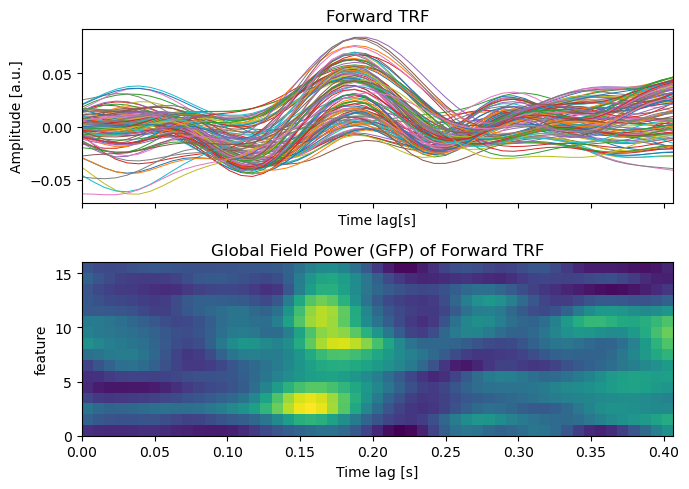

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
fwd_trf_spect.plot(feature=6, axes=ax[0], show=False)
fwd_trf_spect.plot(channel='gfp', axes=ax[1], kind='image', show=False)
ax[0].set_title('Forward TRF')
ax[1].set_title('Global Field Power (GFP) of Forward TRF')
plt.tight_layout()
plt.show()

#### Excercise
Use cross-validation to train the model. Did you notice any difference in the model performance compared to using the envelope as stimulus feature?

In [19]:
# Use cross-validation to estimate the model's generalization performance
r_fwd_spect = crossval(
    model=TRF(direction=1), 
    stimulus=stimulus_spectrogram,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=1000
)
print(f"mean correlation between actual and predicted response: {r_fwd_spect.mean().round(3)}")

Cross-validating[##################################################] 10/10

mean correlation between actual and predicted response: 0.022


#### Excercise
Try to optimize the regularization parameter for the multivariate model. How does the value of the best regularization parameter compare to the one we found for th univariate model? 

Cross-validating[##################################################] 10/10....] 0/10

Cross-validating[##################################################] 10/10....] 1/10

Cross-validating[##################################################] 10/10....] 2/10

Cross-validating[##################################################] 10/10....] 3/10

Cross-validating[##################################################] 10/10....] 4/10

Cross-validating[##################################################] 10/10....] 5/10

Cross-validating[##################################################] 10/10....] 6/10

Cross-validating[##################################################] 10/10....] 7/10

Cross-validating[##################################################] 10/10....] 8/10

Cross-validating[##################################################] 10/10....] 9/10

Hyperparameter optimization[##################################################] 10/10



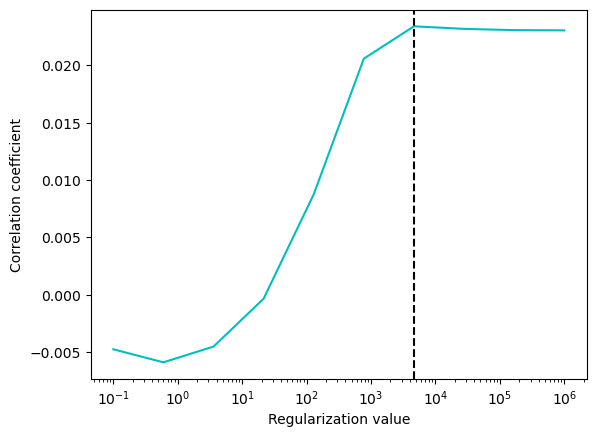

Best regularization value: 4641.589, r=0.023


In [20]:
# Use a range of regularization values to find the best value
regularization = np.logspace(-1, 6, 10)

trf = TRF(metric=pearsonr)  # use pearsons correlation
r = trf.train(
    stimulus=stimulus_spectrogram,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=regularization
)
fig, ax = plt.subplots()
ax.semilogx(regularization, r, color='c')
ax.set(xlabel='Regularization value', ylabel='Correlation coefficient')
ax.axvline(regularization[np.argmax(r)], linestyle='--', color='k')
plt.show()
print(f"Best regularization value: {regularization[np.argmax(r)].round(3)}, r={r.max().round(3)}")

#### Excercise
Finally, perform statistical inference using permutation testing as above. Does the multivariate model yield a significant result? 

Preparing models[##################################################] 100/100

Permuting[##################################################] 100/100



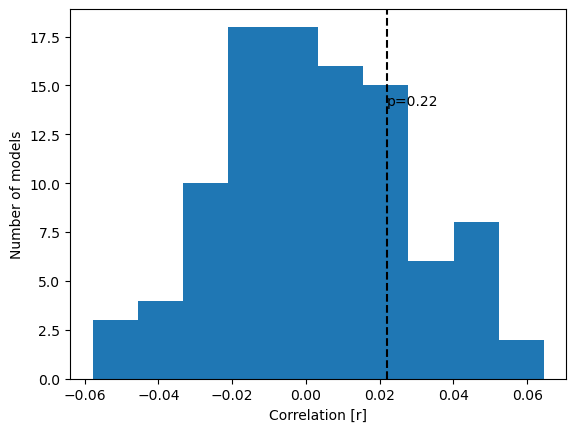

In [21]:
r_obs = 0.022 # the previously observed correlation
regularization = 4642 # the lambda value that worked best
n_permute = 100
 # number of permutations
trf = TRF()  # use forward model
tmin, tmax = 0, 0.4  # range of time lags
r_perm = permutation_distribution(
    model=trf,
    stimulus=stimulus_spectrogram,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=regularization,
    n_permute=n_permute
)
p = sum(r_perm>=r_obs)/len(r_perm)
plt.hist(r_perm, bins=10)
plt.axvline(x=r_obs, ymin=0, ymax=1, color='black', linestyle='--')
plt.xlabel('Correlation [r]')
plt.ylabel('Number of models')
plt.annotate(f'p={p.round(3)}', (r_obs, 14))
plt.show()

## 4. Backward model (Decoding)
So far we have only used the TRF model to predict the EEG response from the stimulus features, which is called the forward (or encodign) model. However, we can also use the TRF model as a backward model, reconstructing the stimulus feature from the EEG response. This is also called decoding. 

To fit a backward model, just change the direction parameter to -1. This will tell the TRF to use the response as predictor to estimate the stimulus. In the example below we are using a backward TRF to predict the acoustic envelope from the neural response. The backward TRF predicts the envelope as a weighted combination of time-lagged responses from all 128 EEG channels. This allows the model to exploit interactions between individual signals (and underlying neural sources) making it more powerful but also computationally expansive and more susceptible to overfitting. 

In [22]:
bwd_trf = TRF(direction=-1)
bwd_trf.train(
    stimulus=stimulus_envelope,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=1000
)
pred_bwd, r_bwd = bwd_trf.predict(stimulus_envelope, response)
print(f"correlation between actual and predicted envelope: {r_bwd.round(3)}")

correlation between actual and predicted envelope: 0.254


We can see that the decoding approach gives a higher reconstruction accuracy than the encoding approach. 

Let's plot the true and predicted envelope from the backward TRF model. 

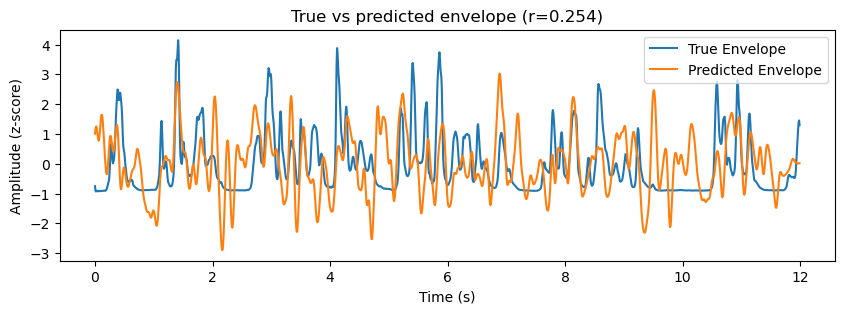

In [23]:
# Plot the true and predicted envelope from the backward model
env_z = zscore(stimulus_envelope[0], axis=0)  # standardize envelope for plotting
pred_bwd_z = zscore(pred_bwd[0], axis=0)  # standardize predicted envelope
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.plot(times, env_z, label='True Envelope')
plt.plot(times, pred_bwd_z, label='Predicted Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (z-score)')
# plt.xlim(4.5, 6.5)
plt.legend()
plt.title(f'True vs predicted envelope (r={r_bwd.round(3)})')
plt.show()

Just as with the forward model, we can use cross-validation to estimate the model's generalization performance and avoid overfitting. The `mtrf.stats.crossval()` function can be used to perform cross-validation for the backward model as well. 

#### Excercise
Use cross-validation to obtain an unbiased estimate of the backward model's accuracy. 

In [24]:
r_bwd = crossval(
    model=bwd_trf,
    stimulus=stimulus_envelope,
    response=response,
    fs=fs,
    tmin=tmin,
    tmax=tmax,
    regularization=1000
)
print(f"correlation between actual and predicted envelope: {r_bwd.round(3)}")

Cross-validating[##################################################] 10/10

correlation between actual and predicted envelope: 0.118


As for visualising the predicted TRFs, it is a bit more complicated than in the forward modelling approach. In the decoding approach, the TRFs are essentially the weights of a multivariate decoding model and as such they must not only amplify the signal of interest (i.e., neural activations) but also suppress all signals of no interest. Therefore it is not recommended to visualize a backward TRF directly (you can read more about this in [Haufe et al. (2014)](https://www.sciencedirect.com/science/article/pii/S1053811913010914?via%3Dihub)). However, we can transform backward to forward models to allow a physiological interpretation of model weights. 

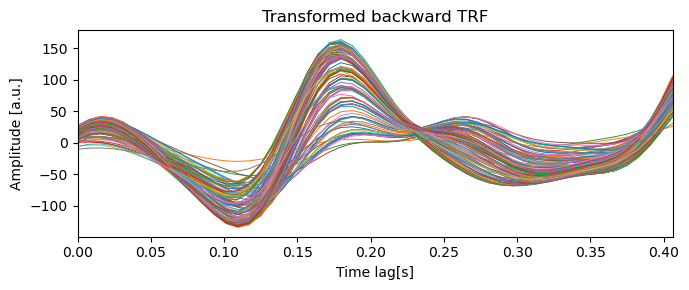

In [25]:
transformed = bwd_trf.to_forward(response)
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_title('Transformed backward TRF')
transformed.plot(axes=ax, show=False)
plt.tight_layout()
plt.show()

#### Excercise
Use the `TRF.to_mne_evoked()` method to convert the forward TRF to MNE-Python's `mne.Evoked` objects and visualize them as we did for the forward model. How do they compare to the forward TRFs?

No projector specified for this dataset. Please consider the method self.add_proj.


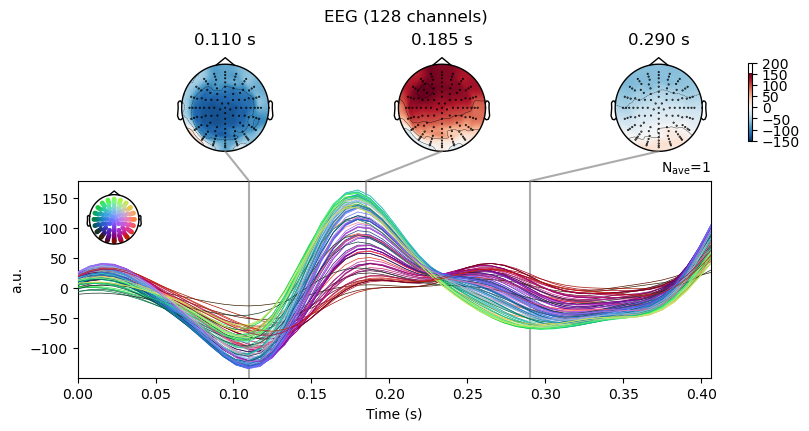

In [26]:
# use standard montage for the EEG system used for recording the response
evokeds_bwd = transformed.to_mne_evoked(montage)
_ = evokeds_bwd[0].plot_joint(
    times=[0.11, 0.185, 0.29], 
    topomap_args={"scalings": 1}, 
    ts_args={"units": "a.u.", "scalings": dict(eeg=1)}
)

No projector specified for this dataset. Please consider the method self.add_proj.


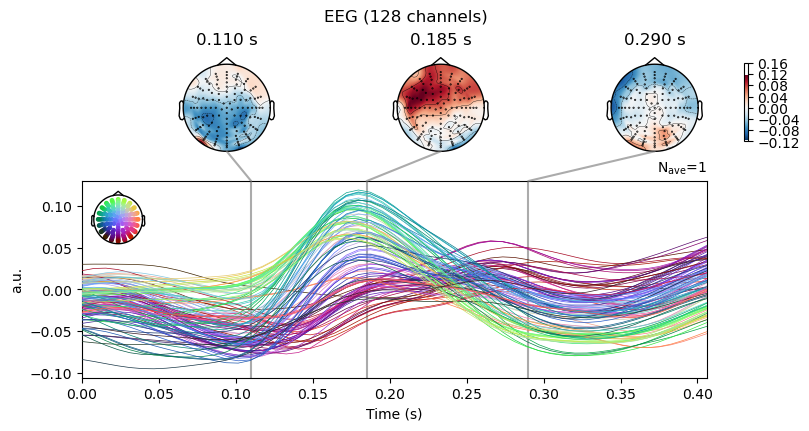

In [27]:
# Plot the forward TRF weights as well for easy comparison
_ = evokeds[0].plot_joint(
    times=[0.11, 0.185, 0.29],
    topomap_args={"scalings": 1},
    ts_args={"units": "a.u.", "scalings": dict(eeg=1)}
)